In [1]:
## Enviroment Setup
import os, sys
WORKING_DIR = '/home/peizhi/Documents/flame-head-tracker'
os.chdir(WORKING_DIR) # change the working directory to the project's absolute path
print("Current Working Directory: ", os.getcwd())

## Computing Device
device = 'cuda:0'
import torch
torch.cuda.set_device(device) # this will solve the problem that OpenGL not on the same device with torch tensors

sys.path.append(WORKING_DIR)
sys.path.append('./utils/flame_lib/')
sys.path.append('./utils/flame_fitting/')
sys.path.append('./utils/face_parsing/')
sys.path.append('./utils/decalib/')
sys.path.append('./utils/mesh_renderer')
sys.path.append('./utils/scene')

import matplotlib.pyplot as plt
import numpy as np

from tracker_base import Tracker




Current Working Directory:  /home/peizhi/Documents/flame-head-tracker
Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:

###########################
## Setup Flame Tracker    #     
###########################

tracker_cfg = {
    'mediapipe_face_landmarker_v2_path': './models/face_landmarker_v2_with_blendshapes.task',
    'flame_model_path': './models/FLAME2020/generic_model.pkl',
    'flame_lmk_embedding_path': './models/landmark_embedding.npy',
    'tex_space_path': './models/FLAME_texture.npz',
    'face_parsing_model_path': './utils/face_parsing/79999_iter.pth',
    'uv_coord_mapping_file_path': './models/uv2vert_256.npy',
    'template_mesh_file_path': './models/head_template.obj',
    'result_img_size': 512,
    'device': device,
}

tracker = Tracker(tracker_cfg)



I0000 00:00:1729124317.474235 3927250 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1729124317.516976 3927514 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 550.107.02), renderer: NVIDIA RTX A6000/PCIe/SSE2
W0000 00:00:1729124317.517582 3927250 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1729124317.531482 3927521 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1729124317.549757 3927531 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


creating the FLAME Decoder


/home/peizhi/Documents/flame-head-tracker/utils/flame_lib/FLAME.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.register_buffer('dynamic_lmk_faces_idx', torch.tensor(lmk_embeddings['dynamic_lmk_faces_idx'], dtype=torch.long))
/home/peizhi/Documents/flame-head-tracker/utils/flame_lib/FLAME.py:82: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.register_buffer('dynamic_lmk_bary_coords', torch.tensor(lmk_embeddings['dynamic_lmk_bary_coords'], dtype=self.dtype))
/home/peizhi/miniconda3/envs/tracker/lib/python3.10/site-packages/pytorch3d/io/obj_io.py:550: UserWarning: Mtl file does not exist: ./models/template.mtl
  warnings.warn(f"Mtl file does not exist: {f}")
/home/peizhi/mini

creating the FLAME Decoder
trained model found. load models/deca_model.tar
Flame Tracker ready.


/home/peizhi/miniconda3/envs/tracker/lib/python3.10/site-packages/pytorch3d/io/obj_io.py:550: UserWarning: Mtl file does not exist: models/template.mtl
  warnings.warn(f"Mtl file does not exist: {f}")


### Reconstruct from a single image



/home/peizhi/miniconda3/envs/tracker/lib/python3.10/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


vertices (5023, 3)
shape (1, 100)
exp (1, 50)
pose (1, 6)
eye_pose (1, 6)
tex (1, 50)
light (1, 9, 3)
cam (6,)
img_rendered (256, 256, 3)
mesh_rendered (256, 256, 3)
img (512, 512, 3)
img_aligned (512, 512, 3)
parsing (512, 512)
parsing_aligned (512, 512)
lmks_dense (478, 2)
lmks_68 (68, 2)
blendshape_scores (52,)


Text(0.5, 1.0, 'mesh_rendered')

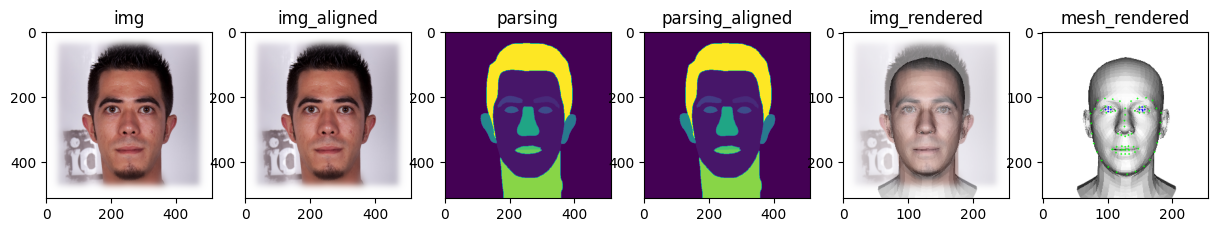

In [4]:
"""
download an example image (from FFHQ dataset):
https://docs.google.com/uc?export=download&id=1vqQHRarSmzeXmhyYwrbmXQUTdZYmsICF

save to ./assets/00012.png
"""

img_path = './assets/00012.png'

ret_dict = tracker.load_image_and_run(img_path, realign=True) # if realign == True, the fitting is on the realigned image
                                                              # otherwise the fitting is on the original image

# check the returned results
for key in ret_dict:
    print(f'{key} {ret_dict[key].shape}')


# plot some results
plt.figure(figsize=(15,6))

plt.subplot(1,6,1)
plt.imshow(ret_dict['img']); plt.title('img')

plt.subplot(1,6,2)
plt.imshow(ret_dict['img_aligned']); plt.title('img_aligned')

plt.subplot(1,6,3)
plt.imshow(ret_dict['parsing']); plt.title('parsing')

plt.subplot(1,6,4)
plt.imshow(ret_dict['parsing_aligned']); plt.title('parsing_aligned')

plt.subplot(1,6,5)
plt.imshow(ret_dict['img_rendered']); plt.title('img_rendered')

plt.subplot(1,6,6)
plt.imshow(ret_dict['mesh_rendered']); plt.title('mesh_rendered')



Text(0.5, 1.0, 'mesh_rendered')

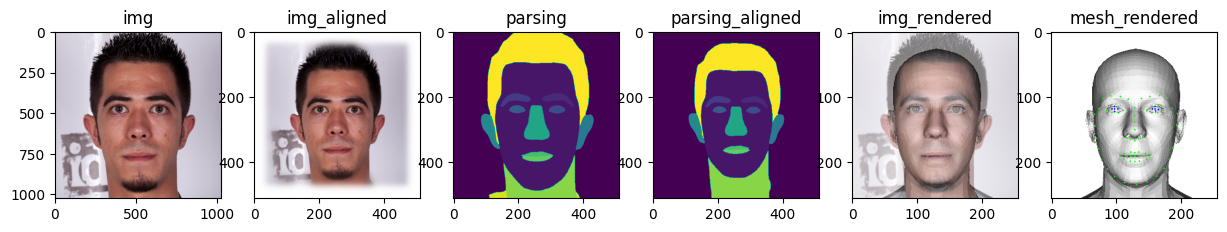

In [5]:
"""
Set realign to False

In this case, we still realign the input image.
However, the reconstruction is on the original image.

"""

img_path = './assets/00012.png'

ret_dict = tracker.load_image_and_run(img_path, realign=False) # if realign == True, the fitting is on the realigned image
                                                               # otherwise the fitting is on the original image

# plot some results
plt.figure(figsize=(15,6))

plt.subplot(1,6,1)
plt.imshow(ret_dict['img']); plt.title('img')

plt.subplot(1,6,2)
plt.imshow(ret_dict['img_aligned']); plt.title('img_aligned')

plt.subplot(1,6,3)
plt.imshow(ret_dict['parsing']); plt.title('parsing')

plt.subplot(1,6,4)
plt.imshow(ret_dict['parsing_aligned']); plt.title('parsing_aligned')

plt.subplot(1,6,5)
plt.imshow(ret_dict['img_rendered']); plt.title('img_rendered')

plt.subplot(1,6,6)
plt.imshow(ret_dict['mesh_rendered']); plt.title('mesh_rendered')
